# import and Functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy import signal
from scipy.fftpack import fft
from scipy import ndimage
from scipy.io import loadmat
from matplotlib.ticker import MaxNLocator
import os
import warnings
warnings.filterwarnings('ignore')
#annots = loadmat('C:\\Users\\llinc\\GitHub\\retina_personal\\0406\\merge\\merge_0224_HMM_RL_G2.5_5min_Q100_6.5mW.mat')
%matplotlib inline

In [2]:
## EqualState assign states with equal possibility for input array x
def EqualState(x, num_state):
    xs=np.sort(x)
    binlen=int(len(x)/num_state-0.5) #round
    edges = xs[np.arange(num_state+1)*binlen]
    xstate=np.zeros(len(x))
    for i in range(num_state):
        xstate[x>=edges[i]] = i
    xstate = xstate.astype(int)
    return xstate, edges

In [3]:
def PIfunc(r, x, v, dt, window):
    negshift=window[0] # second
    posshift=window[1] # second
    shiftlen=(posshift-negshift)/dt+1
    timeshift=np.linspace(negshift,posshift,int(shiftlen))
    bitshift=np.linspace(negshift/dt,posshift/dt,int(shiftlen),dtype = 'int16')
    Information = dict()
    Information[('BROJA_2PID','SI')]=np.zeros(len(bitshift))
    Information[('BROJA_2PID','UIx')]=np.zeros(len(bitshift))
    Information[('BROJA_2PID','UIv')]=np.zeros(len(bitshift))
    Information[('BROJA_2PID','CI')]=np.zeros(len(bitshift))
    Information[('Beer','Red')]=np.zeros(len(bitshift))
    Information[('Beer','UIx')]=np.zeros(len(bitshift))
    Information[('Beer','UIv')]=np.zeros(len(bitshift))
    Information[('Beer','Syn')]=np.zeros(len(bitshift))
    
    Information[('test','SI')]=np.zeros(len(bitshift))
    Information[('test','UIx')]=np.zeros(len(bitshift))
    Information[('test','UIv')]=np.zeros(len(bitshift))
    Information[('test','CI')]=np.zeros(len(bitshift))
    # shifted data
    # shift>0 => y shifted to positive side
    for i in range(len(bitshift)):
        xx=[]
        vv=[]
        rr=[]
        shift=bitshift[i]
        if shift>0:
            xx=x[shift:]
            vv=v[shift:]
            rr=r[:(-1*shift)]
        elif shift==0:
            xx=x
            vv=v
            rr=r
        elif shift<0:
            xx=x[:shift]
            vv=v[:shift]
            rr=r[(-1*shift):]
        #find weight of each states by 3D histogram 
        xedges = np.append(np.unique(xx),(max(xx)+1))
        vedges = np.append(np.unique(vv),(max(vv)+1))
        redges = np.append(np.unique(rr),(max(rr)+1))
        dat = np.concatenate((xx[:,np.newaxis], vv[:,np.newaxis],rr[:,np.newaxis]), axis=1)
        N, edges = np.histogramdd(dat, bins=(xedges, vedges, redges))
        #Calculate all kinds of probability and make sure the shape of them, 0 -> x, 1 -> v, 2 -> r
        px=(np.sum(N,axis=(1,2))/np.sum(N))[:, np.newaxis, np.newaxis]
        pv=(np.sum(N,axis=(0,2))/np.sum(N))[np.newaxis, :, np.newaxis]
        pr=(np.sum(N,axis=(0,1))/np.sum(N))[np.newaxis ,np.newaxis, :]
        pxv=(np.sum(N,axis=2)/np.sum(N))[:, :, np.newaxis]
        pxr=(np.sum(N,axis=1)/np.sum(N))[:, np.newaxis, :]
        pvr=(np.sum(N,axis=0)/np.sum(N))[np.newaxis, :, :]
        pxvr=(N/np.sum(N))
        
        Information[('test','UIx')][i] = np.nansum(pxvr*np.log2(pxvr*px/pxv/pxr))/dt
        Information[('test','UIv')][i] = np.nansum(pxvr*np.log2(pxvr*pv/pxv/pvr))/dt


        MIxr=np.nansum(pxr*np.log2(pxr/px/pr))/dt
        MIvr=np.nansum(pvr*np.log2(pvr/pv/pr))/dt
        MIxvR=np.nansum(pxvr*np.log2(pxvr/pxv/pr))/dt
        PI_xR = np.nansum(pxr*np.log2(pxr/px/pr), axis = (0,1))
        PI_vR = np.nansum(pvr*np.log2(pvr/pv/pr), axis = (0,1))
        R = sum(np.minimum(PI_xR, PI_vR))/dt
        Information[('Beer','Red')][i] = R
        Information[('Beer','UIx')][i] = MIxr - R
        Information[('Beer','UIv')][i] = MIvr - R
        Information[('Beer','Syn')][i] = MIxvR - MIxr - MIvr + R

    return timeshift, Information

In [4]:
def Spike_Time_Generater(rdt, dt, Garmma=1):
    rdt = rdt*Garmma
    Spike_time = []
    
    counter = 0
    post_remainer_c = 0
    p = 1
    while True:
        the_random_number = 1-np.random.rand()
        while (the_random_number < p and counter < len(rdt)):
            p *= np.exp(-rdt[counter])
            counter += 1
        if counter >= len(rdt):
            break
        remainer_c = -np.log(p/the_random_number)/rdt[counter-1]
#         if remainer_c>=1 or remainer_c<=0:
#             print('shit!')
        Spike_time.append(dt*(counter-remainer_c))
        p = np.exp(-remainer_c*rdt[counter-1])
    return Spike_time[::Garmma]

# activation function
def NL(x,theta=0):
    y = np.zeros(len(x))
    for i in range(len(x)):
        if x[i]- theta>0:
            y[i]= x[i]-theta
    return(y)

# chose file

In [5]:
dt = 0.01
Tot=300
T=np.arange(dt,Tot,dt)
tau= 1
D = 27*10**5
OU=np.zeros(len(T))
mu, sigma = 0, 1
for i in range(len(T)-1):
    OU[i+1]=OU[i]*(1-dt/tau)+math.sqrt(D*dt)*np.random.normal(mu,sigma)
OU = (OU-np.mean(OU))/np.std(OU)

# filtering for OUSmoothed
Fc = 1
b, a = signal.butter(2, 2*Fc*dt, btype='low', analog=False)
x = signal.filtfilt(b, a, OU)
x = x.astype(float)

In [6]:
x = x.astype(float)
x = (x -np.mean(x))/np.std(x)
x_cor = np.correlate(x, x, "same")
x_cor = x_cor[:int((len(x_cor)+1)/2)+1]
Taxis = np.flip(T[:len(x_cor)]-dt*3/2)
t_cor = np.interp(0.5*max(x_cor),  x_cor, Taxis)
tv = ndimage.gaussian_filter1d(x, sigma=int(t_cor/dt*0.1), order=1, mode='reflect') / dt
v=np.append(0, np.diff(x)/dt)
# v = (v -np.mean(v))/np.std(v)
print(t_cor)

0.8889887108144459


# Set $\lambda$s

In [7]:
Lambdas =  np.append(np.arange(0,1.0,0.1),1.0)

In [8]:
##response
# Model one: simple estimation
window = [-1,1] # second
Information_list = []
dvInformation_list = []
for Lambda in Lambdas:
    r = (1-Lambda)*x+v*Lambda
    #assign states
    r = NL(np.mean(r)-r, 0)
#     ratio = sum(r)/T[-1]/12
#     FakeSpike = Spike_Time_Generater(r/ratio, dt, 10)
#     rstate, _ = np.histogram(FakeSpike, np.append(0,T))
#     rstate = rstate.astype(int)
    rstate,edge = EqualState(r, 6)
    xstate,edge = EqualState(x, 6)
    vstate,edge = EqualState(v, 6)
    tvstate,edge = EqualState(tv, 6)
    #calculate information
    timeshift, Information = PIfunc(rstate, xstate, vstate, dt, window)
    timeshift, dvInformation = PIfunc(rstate, xstate, tvstate, dt, window)
    Ux = Information[('Beer','UIx')]
    Uv = Information[('Beer','UIv')]
    Syner = Information[('Beer','Syn')]
    Redun = Information[('Beer','Red')]
    Information_list.append(Information)
    dvInformation_list.append(dvInformation)
#         ax.plot(Ux+Uv+Redun+Syner)

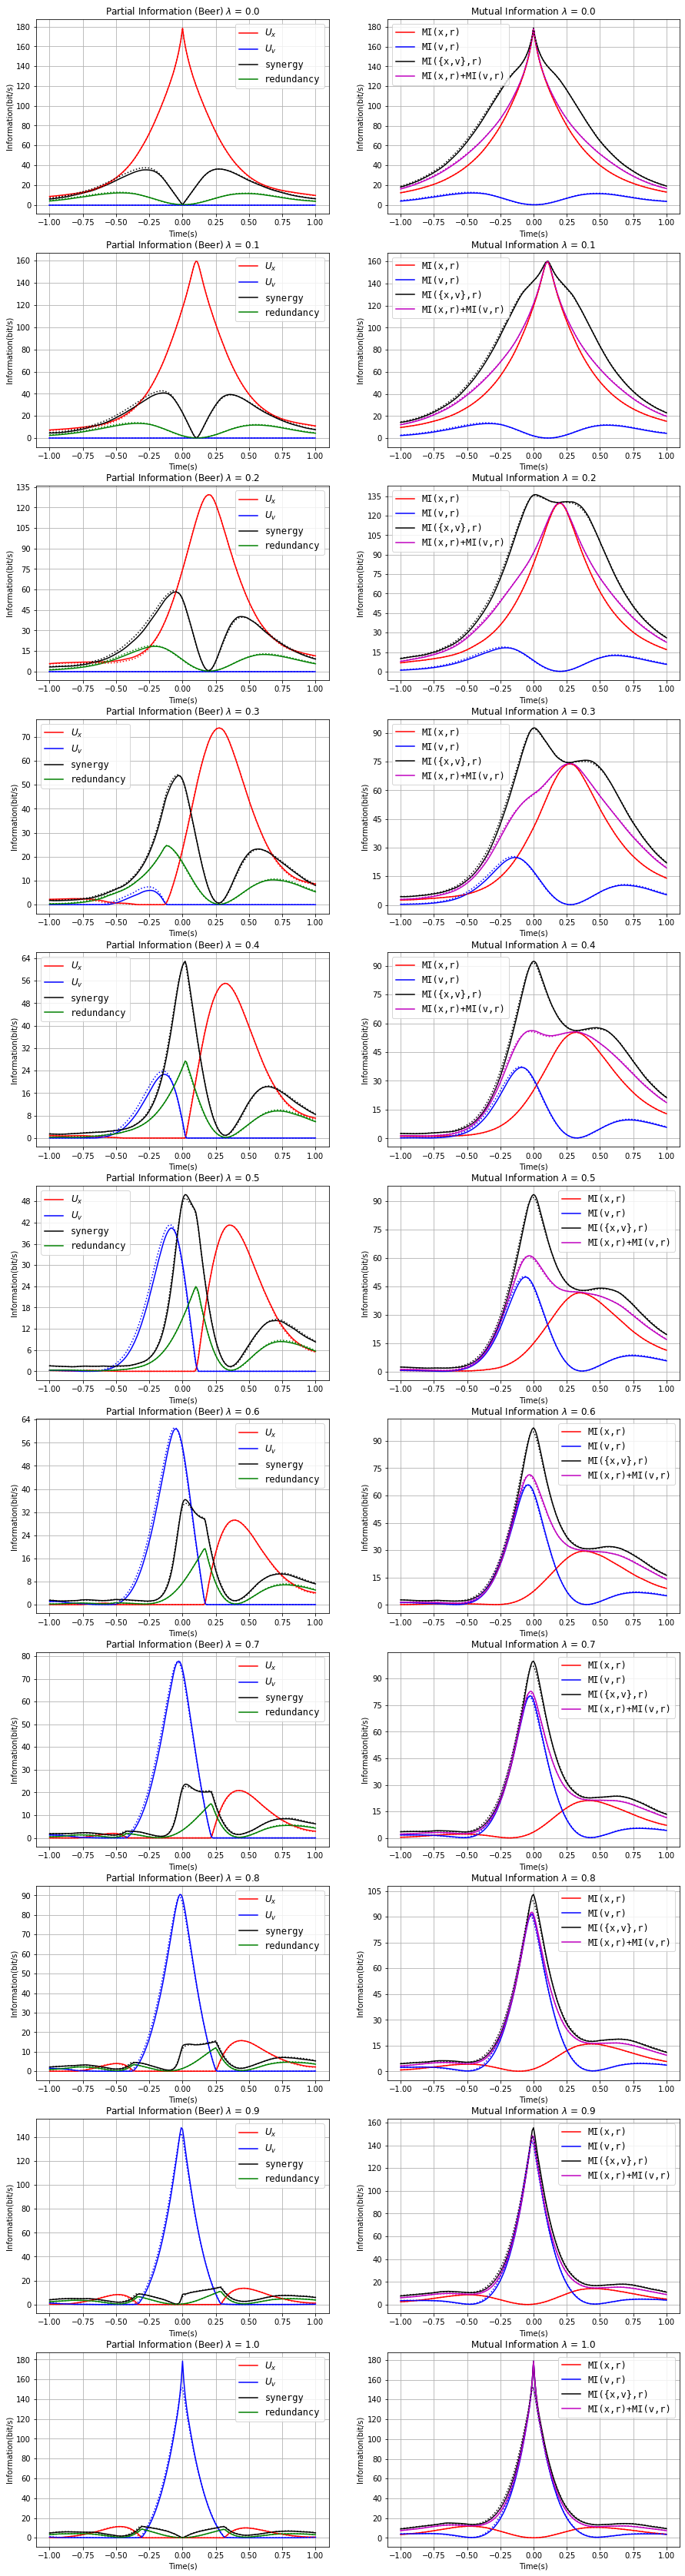

In [9]:
fig, ax = plt.subplots(nrows=len(Information_list), ncols=2)
for i in range(len(Information_list)): 
    ax[i][0].plot(timeshift,Information_list[i][('Beer','UIx')], 'r-')
    ax[i][0].plot(timeshift,Information_list[i][('Beer','UIv')], 'b-')
    ax[i][0].plot(timeshift,Information_list[i][('Beer','Syn')], 'k-')
    ax[i][0].plot(timeshift,Information_list[i][('Beer','Red')], 'g-')
    
    ax[i][0].plot(timeshift,dvInformation_list[i][('Beer','UIx')], 'r:')
    ax[i][0].plot(timeshift,dvInformation_list[i][('Beer','UIv')], 'b:')
    ax[i][0].plot(timeshift,dvInformation_list[i][('Beer','Syn')], 'k:')
    ax[i][0].plot(timeshift,dvInformation_list[i][('Beer','Red')], 'g:')
    ax[i][0].yaxis.set_major_locator(MaxNLocator(integer=True))
    ax[i][0].set_title('Partial Information (Beer) '+r'$\lambda$ = '+str(round(Lambdas[i],1)))
    ax[i][0].set_xlabel('Time(s)')
    ax[i][0].set_ylabel('Information(bit/s)')
    ax[i][0].legend( (r'$U_x$', r'$U_v$', 'synergy', 'redundancy'), loc='best', prop={'size': 'large', 'family': 'monospace'})
    ax[i][0].grid()
    
    #plot MIs
    ax[i][1].plot(timeshift,Information_list[i][('Beer','UIx')]+Information_list[i][('Beer','Red')], 'r-')
    ax[i][1].plot(timeshift,Information_list[i][('Beer','UIv')]+Information_list[i][('Beer','Red')], 'b-')
    ax[i][1].plot(timeshift,Information_list[i][('Beer','UIx')]+Information_list[i][('Beer','Red')]+
                  Information_list[i][('Beer','UIv')]+Information_list[i][('Beer','Syn')], 'k-')
    ax[i][1].plot(timeshift,Information_list[i][('Beer','UIx')]+2*Information_list[i][('Beer','Red')]+
                  Information_list[i][('Beer','UIv')], 'm-')
    ax[i][1].plot(timeshift,dvInformation_list[i][('Beer','UIx')]+dvInformation_list[i][('Beer','Red')], 'r:')
    ax[i][1].plot(timeshift,dvInformation_list[i][('Beer','UIv')]+dvInformation_list[i][('Beer','Red')], 'b:')
    ax[i][1].plot(timeshift,dvInformation_list[i][('Beer','UIx')]+dvInformation_list[i][('Beer','Red')]+
                  dvInformation_list[i][('Beer','UIv')]+dvInformation_list[i][('Beer','Syn')], 'k:')
    ax[i][1].plot(timeshift,dvInformation_list[i][('Beer','UIx')]+2*dvInformation_list[i][('Beer','Red')]+
                  dvInformation_list[i][('Beer','UIv')], 'm:')
    ax[i][1].yaxis.set_major_locator(MaxNLocator(integer=True))
    ax[i][1].set_title('Mutual Information '+r'$\lambda$ = '+str(round(Lambdas[i],1)))
    ax[i][1].set_xlabel('Time(s)')
    ax[i][1].set_ylabel('Information(bit/s)')
    ax[i][1].grid()
    ax[i][1].legend( ('MI(x,r)', 'MI(v,r)', 'MI({x,v},r)', 'MI(x,r)+MI(v,r)'), loc='best', prop={'size': 'large', 'family': 'monospace'})
fig.set_size_inches(15, 5.5*len(Information_list))

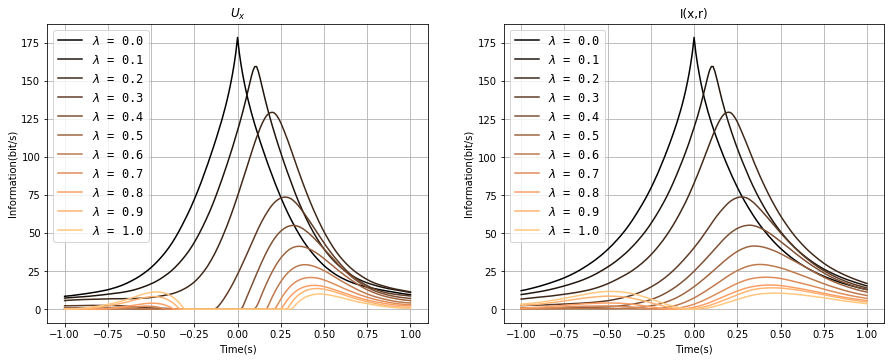

In [10]:
fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].set_prop_cycle(plt.cycler('color', plt.cm.copper(np.linspace(0, 1, len(Information_list)))))
ax[1].set_prop_cycle(plt.cycler('color', plt.cm.copper(np.linspace(0, 1, len(Information_list)))))
for i in range(len(Information_list)): 
    ax[0].plot(timeshift,Information_list[i][('Beer','UIx')])
    ax[1].plot(timeshift,Information_list[i][('Beer','UIx')]+Information_list[i][('Beer','Red')])
ax[0].set_title(r'$U_x$')
ax[0].set_xlabel('Time(s)')
ax[0].set_ylabel('Information(bit/s)')
ax[0].legend( [r'$\lambda$ = '+str(round(Lambda,1)) for Lambda in Lambdas], loc='best', prop={'size': 'large', 'family': 'monospace'})
ax[0].grid()
ax[1].set_title('I(x,r)')
ax[1].set_xlabel('Time(s)')
ax[1].set_ylabel('Information(bit/s)')
ax[1].legend( [r'$\lambda$ = '+str(round(Lambda,1)) for Lambda in Lambdas], loc='best', prop={'size': 'large', 'family': 'monospace'})
ax[1].grid()
fig.set_size_inches(15, 5.5)

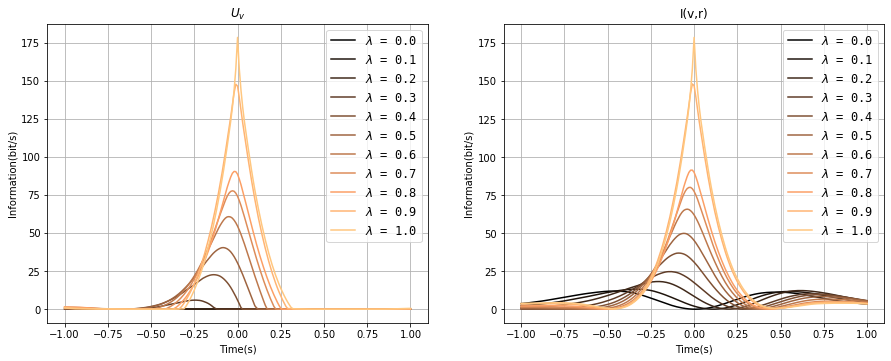

In [11]:
fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].set_prop_cycle(plt.cycler('color', plt.cm.copper(np.linspace(0, 1, len(Information_list)))))
ax[1].set_prop_cycle(plt.cycler('color', plt.cm.copper(np.linspace(0, 1, len(Information_list)))))
for i in range(len(Information_list)): 
    ax[0].plot(timeshift,Information_list[i][('Beer','UIv')])
    ax[1].plot(timeshift,Information_list[i][('Beer','UIv')]+Information_list[i][('Beer','Red')])
ax[0].set_title(r'$U_v$')
ax[0].set_xlabel('Time(s)')
ax[0].set_ylabel('Information(bit/s)')
ax[0].legend( [r'$\lambda$ = '+str(round(Lambda,1)) for Lambda in Lambdas], loc='best', prop={'size': 'large', 'family': 'monospace'})
ax[0].grid()
ax[1].set_title('I(v,r)')
ax[1].set_xlabel('Time(s)')
ax[1].set_ylabel('Information(bit/s)')
ax[1].legend( [r'$\lambda$ = '+str(round(Lambda,1)) for Lambda in Lambdas], loc='best', prop={'size': 'large', 'family': 'monospace'})
ax[1].grid()
fig.set_size_inches(15, 5.5)

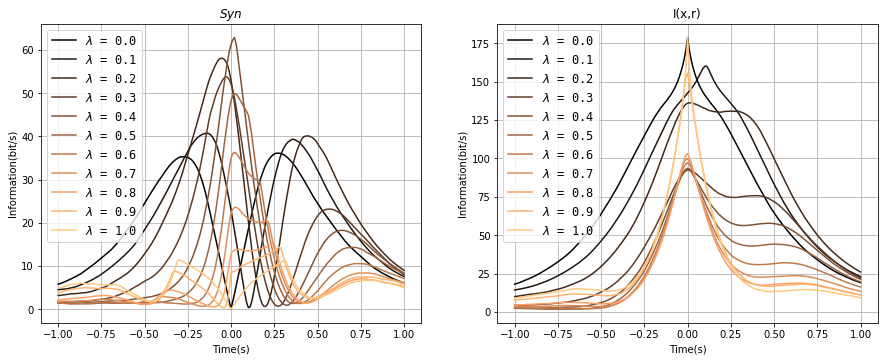

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].set_prop_cycle(plt.cycler('color', plt.cm.copper(np.linspace(0, 1, len(Information_list)))))
ax[1].set_prop_cycle(plt.cycler('color', plt.cm.copper(np.linspace(0, 1, len(Information_list)))))
for i in range(len(Information_list)): 
    ax[0].plot(timeshift,Information_list[i][('Beer','Syn')])
#     ax[0].plot(timeshift,Information_list[i][('Beer','Red')], linestyle = 'dashed')
    ax[1].plot(timeshift,Information_list[i][('Beer','UIx')]+Information_list[i][('Beer','Red')]+Information_list[i][('Beer','UIv')]+Information_list[i][('Beer','Syn')])
ax[0].set_title(r'$Syn$')
ax[0].set_xlabel('Time(s)')
ax[0].set_ylabel('Information(bit/s)')
ax[0].legend( [r'$\lambda$ = '+str(round(Lambda,1)) for Lambda in Lambdas], loc='best', prop={'size': 'large', 'family': 'monospace'})
ax[0].grid()
ax[1].set_title('I(x,r)')
ax[1].set_xlabel('Time(s)')
ax[1].set_ylabel('Information(bit/s)')
ax[1].legend( [r'$\lambda$ = '+str(round(Lambda,1)) for Lambda in Lambdas], loc='best', prop={'size': 'large', 'family': 'monospace'})
ax[1].grid()
fig.set_size_inches(15, 5.5)